

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

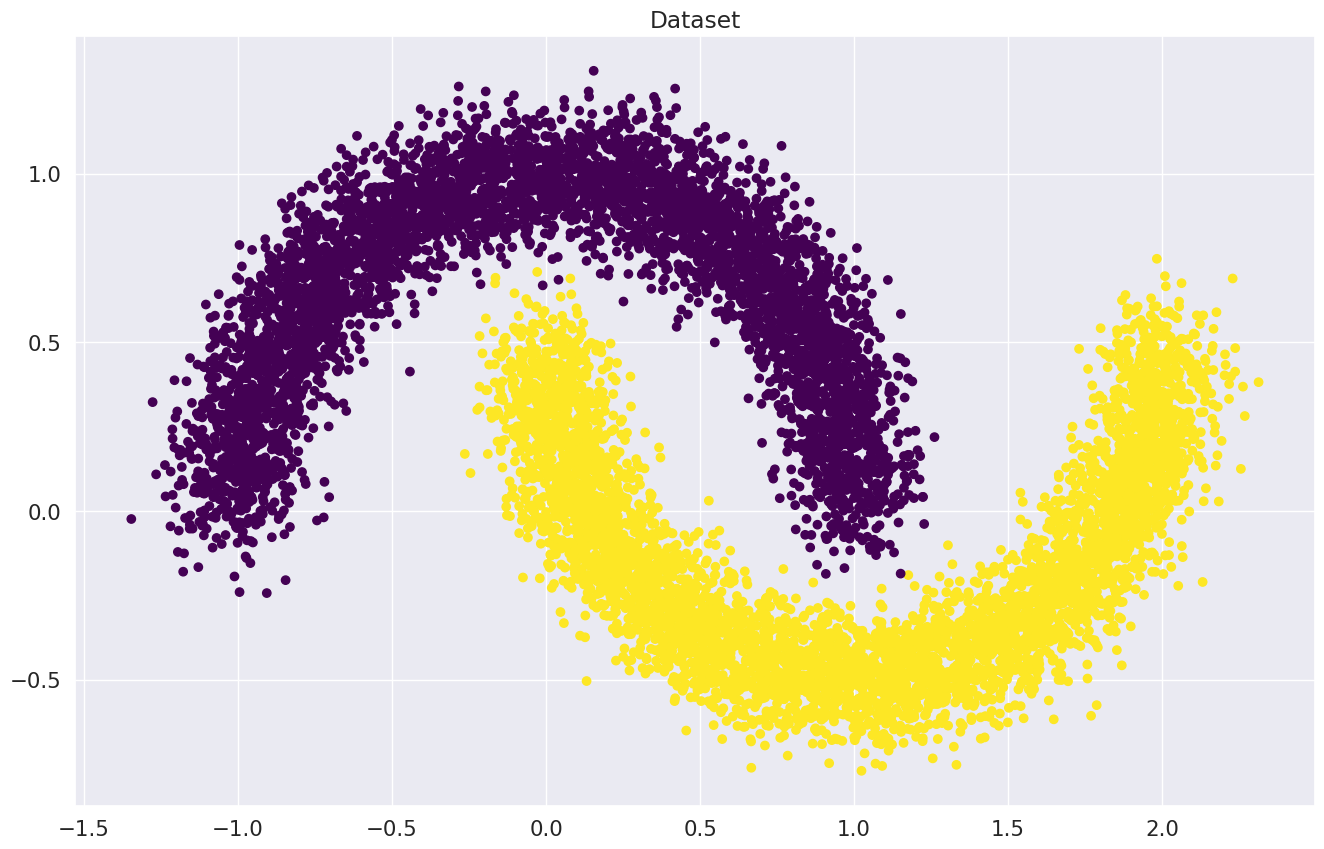

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.FloatTensor(X_train) # MY CODE GOES HERE
y_train_t =  torch.LongTensor(y_train)  # MY CODE GOES HERE
X_val_t =    torch.FloatTensor(X_val)   # MY CODE GOES HERE
y_val_t =    torch.LongTensor(y_val)    # MY CODE GOES HERE

In [6]:
X_train_t.shape, X_train.shape

(torch.Size([7500, 2]), (7500, 2))

Создаем `Dataset` и `DataLoader`.

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset =   TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader   = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)  # MY CODE GOES HERE
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features, 1), requires_grad=True)      # MY CODE GOES HERE


    def forward(self, x):
        x = x @ self.weights   # MY CODE GOES HERE
        if self.bias:
            x +=  self.bias_term        # MY CODE GOES HERE
        return x

In [19]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [12]:
n_params = 0

for param in linear_regression.parameters():
    n_params += param.numel()
print(f'Количество обучаемых параметров модели = {n_params}')

Количество обучаемых параметров модели = 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [20]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch)                                # MY CODE. Use linear_regression to get outputs
        loss =  loss_function(outp, y_batch.reshape_as(outp).double())            # MY CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = 1.0 / (1. + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)


        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        #print(f'batch_acc = {batch_acc}; loss = {loss}')
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5078125
Iteration: 100
Batch accuracy: 0.828125
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 759.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 759 итераций

### Визуализируем результаты

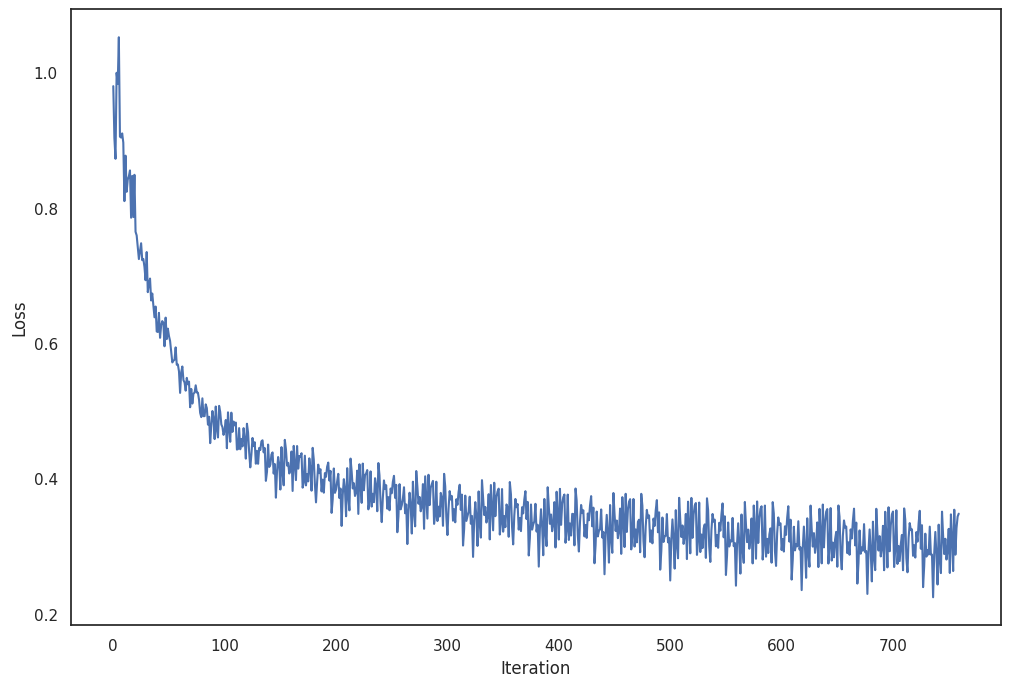

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

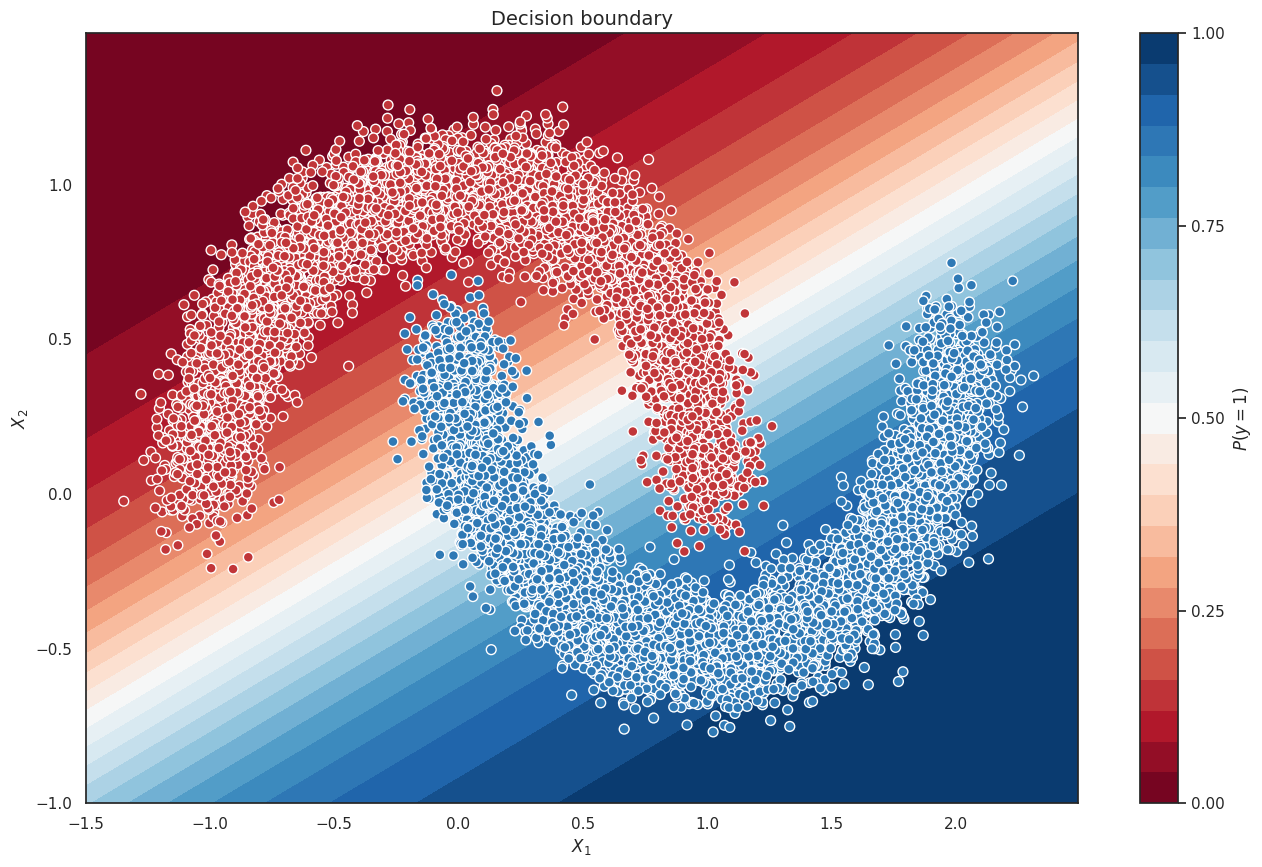

In [23]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [24]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # <MY CODE>
        preds = 1 / (1 + torch.exp(-model.forward(x_batch)))
        predictions = np.hstack((predictions, preds.numpy().flatten()))
        predictions[predictions >= 0.5] = 1
        predictions[predictions < 0.5]  = 0
    return predictions.flatten()

In [25]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
y_pred = predict(val_dataloader, linear_regression)
acc = accuracy_score(y_val_t, y_pred)
acc

0.8636

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8636

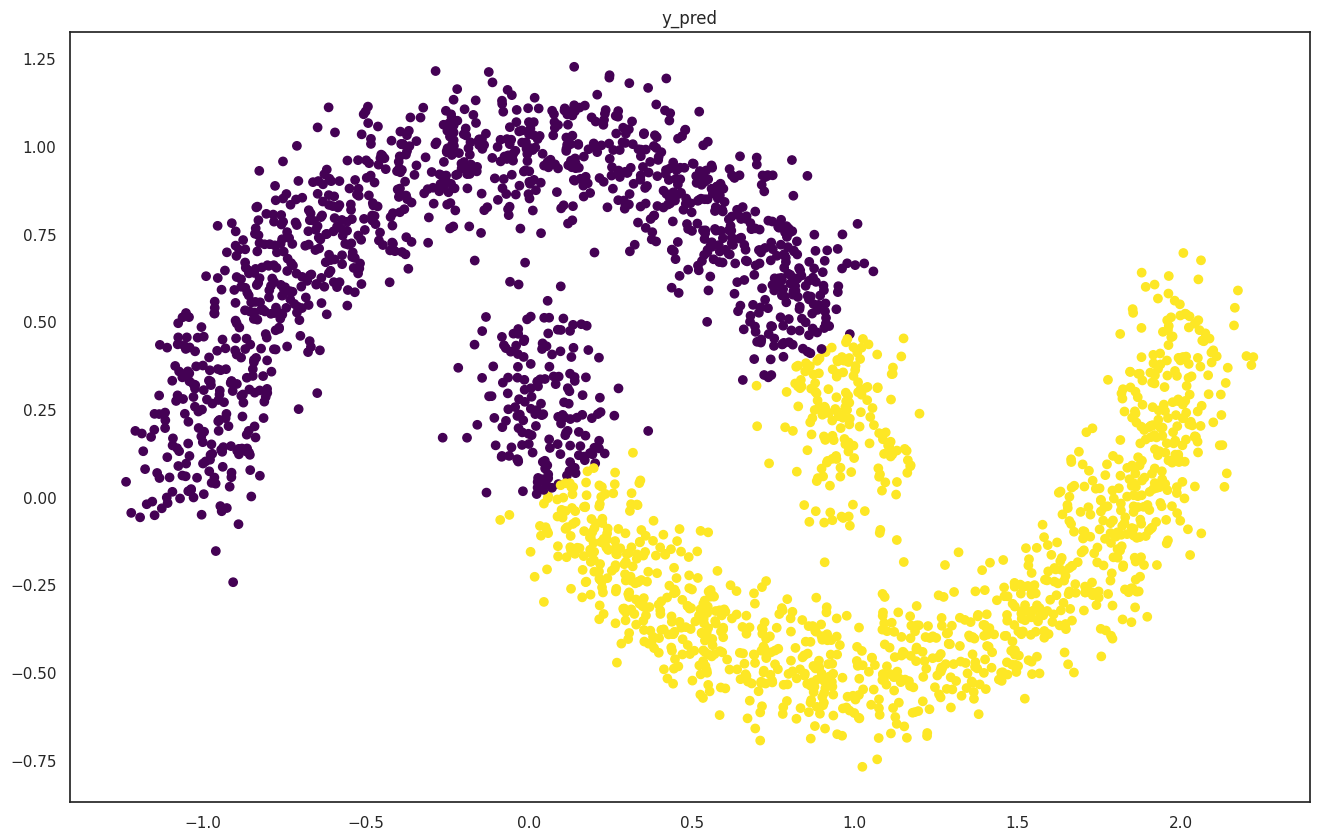

In [27]:
# визуализация предсказаний
plt.figure(figsize=(16, 10))
plt.title("y_pred")
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_pred, cmap="viridis")
plt.show()

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [28]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle=True)  # MY CODE GOES HERE
valid_dataloader =  torch.utils.data.DataLoader(val_dataset,   batch_size = 16, shuffle=False) # MY CODE GOES HERE

100%|██████████| 9912422/9912422 [00:00<00:00, 217705795.85it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44964994.00it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 76802276.53it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5418239.13it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [29]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [30]:
activation = nn.ELU

in_features = np.prod(train_dataloader.dataset.train_data.shape[1 : ])
print(f'in_features = {in_features}')

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features = in_features, out_features = 128),
    activation(),
    nn.Linear(in_features = 128, out_features = 128),
    activation(),
    nn.Linear(in_features= 128, out_features=10)
)

in_features = 784


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [31]:
criterion = torch.nn.CrossEntropyLoss()           #MY CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [33]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                # MY CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)


            else:
                # MY CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)


            preds = outp.argmax(-1)
            correct =  len(preds[preds == y_batch])              # MY CODE GOES HERE
            all =  len(preds)                                    # YOUR CODE GOES HERE
            #print(correct, all)
            epoch_correct += correct
            epoch_all += all


            if k == "train":
                loss = criterion(outp, y_batch)
                # MY CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9133333333333333
Loader: valid. Accuracy: 0.9548
Epoch: 2
Loader: train. Accuracy: 0.9574666666666667
Loader: valid. Accuracy: 0.9623
Epoch: 3
Loader: train. Accuracy: 0.9656333333333333
Loader: valid. Accuracy: 0.9692
Epoch: 4
Loader: train. Accuracy: 0.9712
Loader: valid. Accuracy: 0.9672
Epoch: 5
Loader: train. Accuracy: 0.9741833333333333
Loader: valid. Accuracy: 0.9684
Epoch: 6
Loader: train. Accuracy: 0.9773833333333334
Loader: valid. Accuracy: 0.9607
Epoch: 7
Loader: train. Accuracy: 0.9787333333333333
Loader: valid. Accuracy: 0.9755
Epoch: 8
Loader: train. Accuracy: 0.9809333333333333
Loader: valid. Accuracy: 0.9761
Epoch: 9
Loader: train. Accuracy: 0.9814
Loader: valid. Accuracy: 0.9779
Epoch: 10
Loader: train. Accuracy: 0.9832166666666666
Loader: valid. Accuracy: 0.9738


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [34]:
elu_accuracy = accuracy["valid"]

In [35]:
def fit_and_eval(model, criterion, optimizer, loaders):
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)


                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)


                preds = outp.argmax(-1)
                correct =  len(preds[preds == y_batch])
                all =  len(preds)
                epoch_correct += correct
                epoch_all += all


                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy


# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
def test_activation_function(activation):
    #MY CODE
    in_features = np.prod(train_dataloader.dataset.train_data.shape[1 : ])
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = in_features, out_features = 128),
        activation(),
        nn.Linear(in_features = 128, out_features = 128),
        activation(),
        nn.Linear(in_features= 128, out_features=10)
    )
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    device = "cuda" if torch.cuda.is_available() else "cpu"

    accuracy = fit_and_eval(model, criterion, optimizer, loaders)

    return accuracy['valid']


In [36]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)              #MY CODE
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)   #MY CODE

Epoch: 1
Loader: train. Accuracy: 0.8668
Loader: valid. Accuracy: 0.8966
Epoch: 2
Loader: train. Accuracy: 0.8868833333333334
Loader: valid. Accuracy: 0.9011
Epoch: 3
Loader: train. Accuracy: 0.8988333333333334
Loader: valid. Accuracy: 0.9108
Epoch: 4
Loader: train. Accuracy: 0.9007666666666667
Loader: valid. Accuracy: 0.8979
Epoch: 5
Loader: train. Accuracy: 0.9035333333333333
Loader: valid. Accuracy: 0.8984
Epoch: 6
Loader: train. Accuracy: 0.9057666666666667
Loader: valid. Accuracy: 0.8972
Epoch: 7
Loader: train. Accuracy: 0.90845
Loader: valid. Accuracy: 0.9045
Epoch: 8
Loader: train. Accuracy: 0.9084666666666666
Loader: valid. Accuracy: 0.9088
Epoch: 9
Loader: train. Accuracy: 0.9102166666666667
Loader: valid. Accuracy: 0.9048
Epoch: 10
Loader: train. Accuracy: 0.9113
Loader: valid. Accuracy: 0.9118
Epoch: 1
Loader: train. Accuracy: 0.90295
Loader: valid. Accuracy: 0.9467
Epoch: 2
Loader: train. Accuracy: 0.9506
Loader: valid. Accuracy: 0.9469
Epoch: 3
Loader: train. Accuracy: 0.9

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

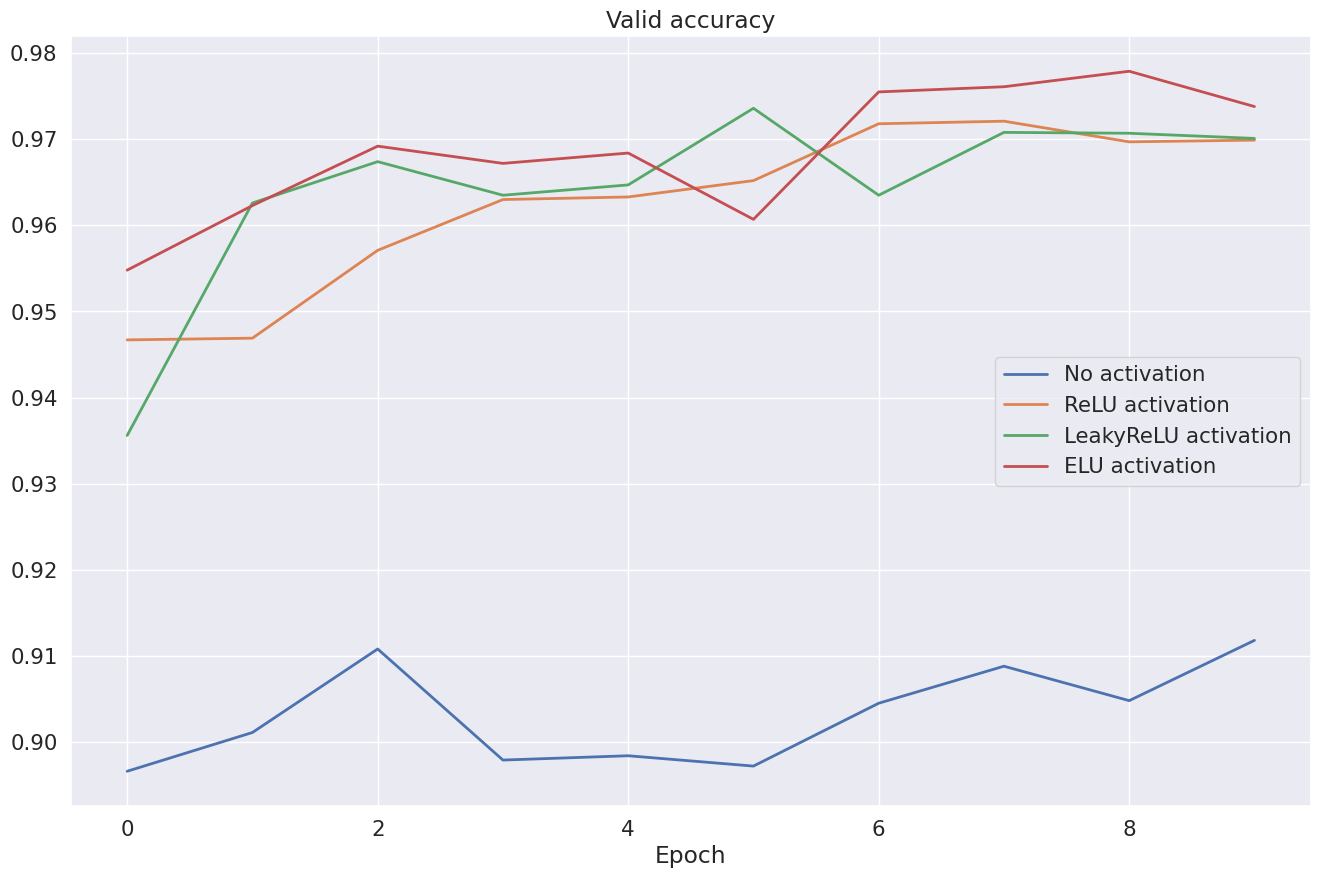

In [37]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

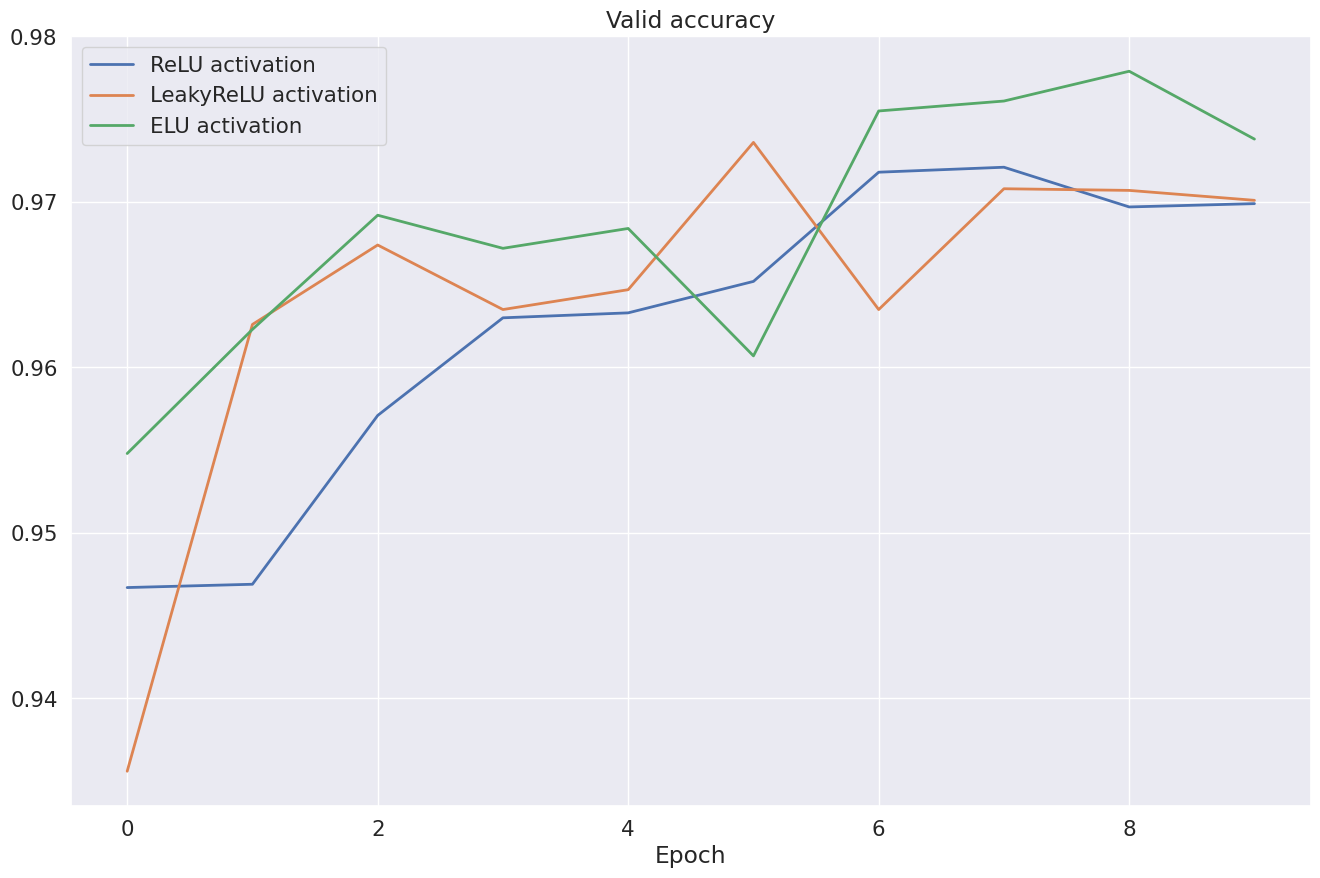

In [39]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU activation

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [40]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-06 18:47:19--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.02s   

2023-11-06 18:47:19 (1.97 MB/s) - ‘sample_photo.jpg’ saved [49337/49337]



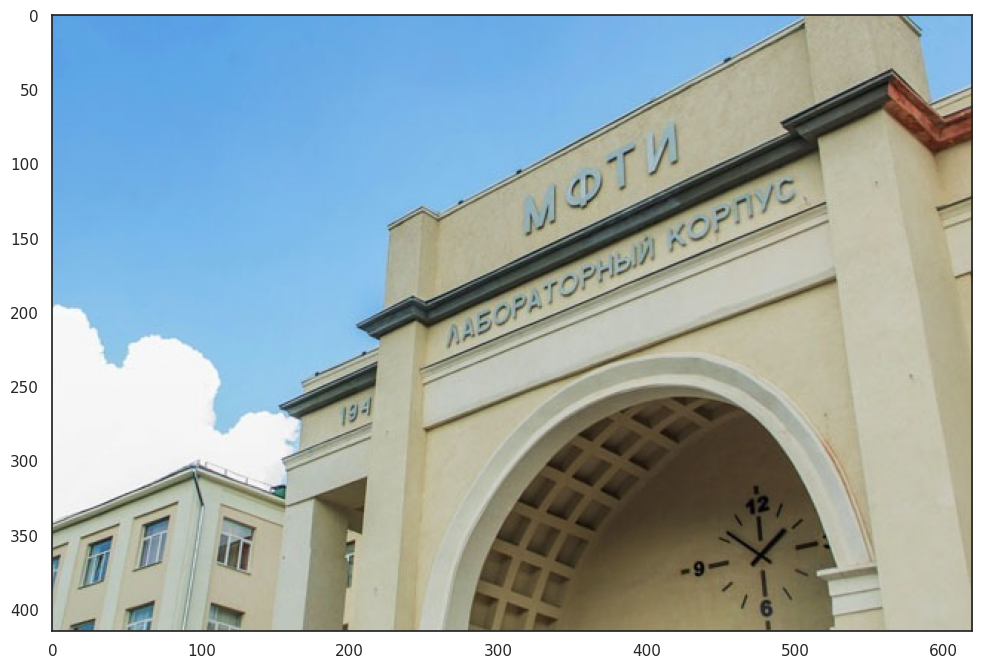

In [42]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [43]:
my_filters = {
    'А': [[0, 0, 0],
          [0, 1, 0],
          [0, 0, 0]],
    'Б': [[0, 1, 0],
          [0, -2, 0],
          [0, 1, 0]],
    'В': [[0, 0, 0],
          [1, -2, 1],
          [0, 0, 0]],
    'Г': [[0, 1, 0],
          [1, -4, 1],
          [0, 1, 0]],
    'Д': [[0, -1, 0],
          [-1, 5, -1],
          [0, -1, 0]],
    'Е': [[0.0625, 0.125, 0.0625],
          [0.125, 0.25, 0.125],
          [0.0625, 0.125, 0.0625]],
}

def show_filter(filter):
    img = cv2.imread("sample_photo.jpg")
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor([
        filter
    ]).reshape(1, 1, 3, 3).type(torch.float32)

    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]  #

    plt.figure(figsize=(8, 6))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    plt.imshow(result_np)
    plt.show()

Фильтр А


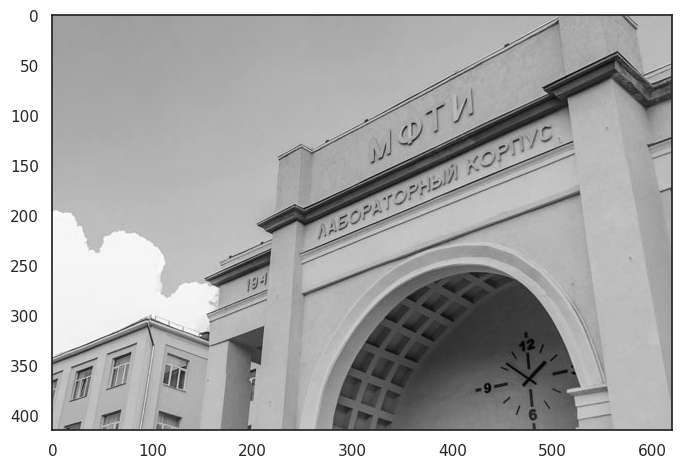

Фильтр Б


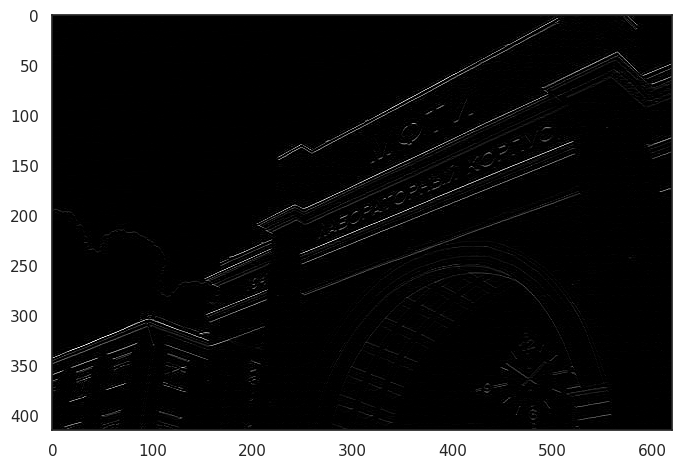

Фильтр В


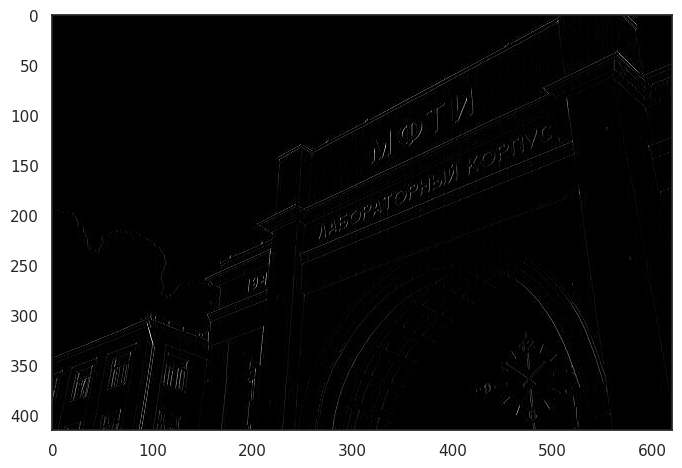

Фильтр Г


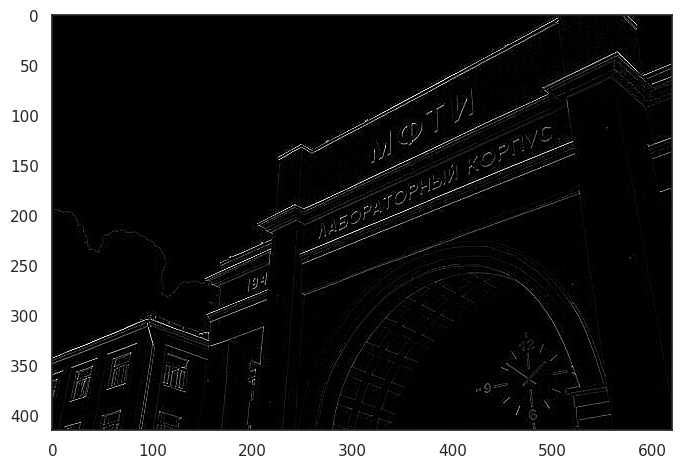

Фильтр Д


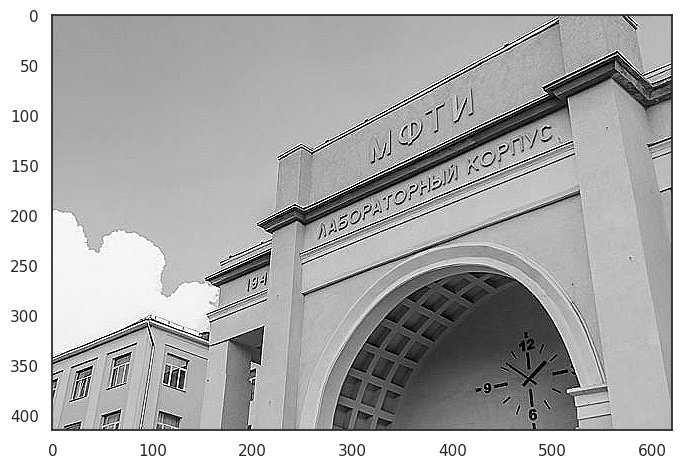

Фильтр Е


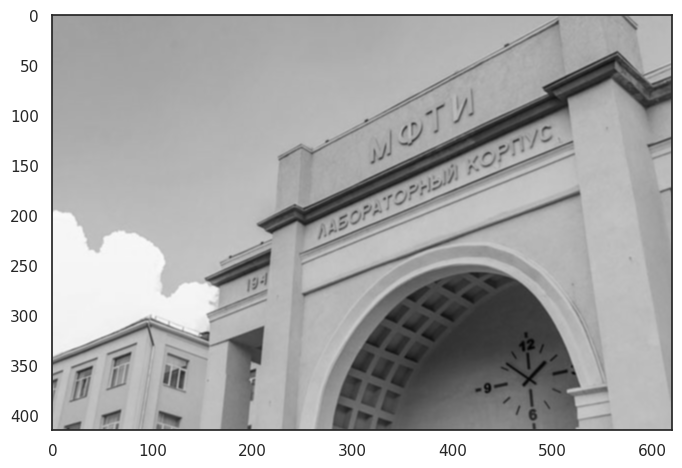

In [44]:
for key in my_filters:
  print(f'Фильтр {key}')
  show_filter(my_filters[key])

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**
 <ol>
 <li>Е</li>
 <li>Д</li>
 <li>А</li>
 <li>Б</li>
 <li>В</li>
 <li>Г</li>
</ol>

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [46]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.act1  = torch.nn.functional.relu
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.act2  = torch.nn.functional.relu
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flat  = nn.Flatten()
        self.fc_act = torch.nn.functional.relu
        self.fc1 = nn.Linear(in_features=400, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84,  out_features=10)


    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.flat(x)
        x = self.fc_act(self.fc1(x))
        x = self.fc_act(self.fc2(x))
        x = self.fc3(x)
        return x


### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [47]:
def fit_and_eval(model, criterion, optimizer, loaders):
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)


                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)


                preds = outp.argmax(-1)
                correct =  len(preds[preds == y_batch])
                all =  len(preds)
                epoch_correct += correct
                epoch_all += all


                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

In [48]:
lenet_model = LeNet()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

accuracy = fit_and_eval(lenet_model, criterion, optimizer, loaders)

Epoch: 1
Loader: train. Accuracy: 0.94325
Loader: valid. Accuracy: 0.9838
Epoch: 2
Loader: train. Accuracy: 0.9813333333333333
Loader: valid. Accuracy: 0.9834
Epoch: 3
Loader: train. Accuracy: 0.9863666666666666
Loader: valid. Accuracy: 0.9856
Epoch: 4
Loader: train. Accuracy: 0.9888333333333333
Loader: valid. Accuracy: 0.9851
Epoch: 5
Loader: train. Accuracy: 0.9910333333333333
Loader: valid. Accuracy: 0.9853
Epoch: 6
Loader: train. Accuracy: 0.9927166666666667
Loader: valid. Accuracy: 0.9865
Epoch: 7
Loader: train. Accuracy: 0.9928
Loader: valid. Accuracy: 0.9896
Epoch: 8
Loader: train. Accuracy: 0.9937666666666667
Loader: valid. Accuracy: 0.9886
Epoch: 9
Loader: train. Accuracy: 0.99445
Loader: valid. Accuracy: 0.9875
Epoch: 10
Loader: train. Accuracy: 0.99515
Loader: valid. Accuracy: 0.988


In [49]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

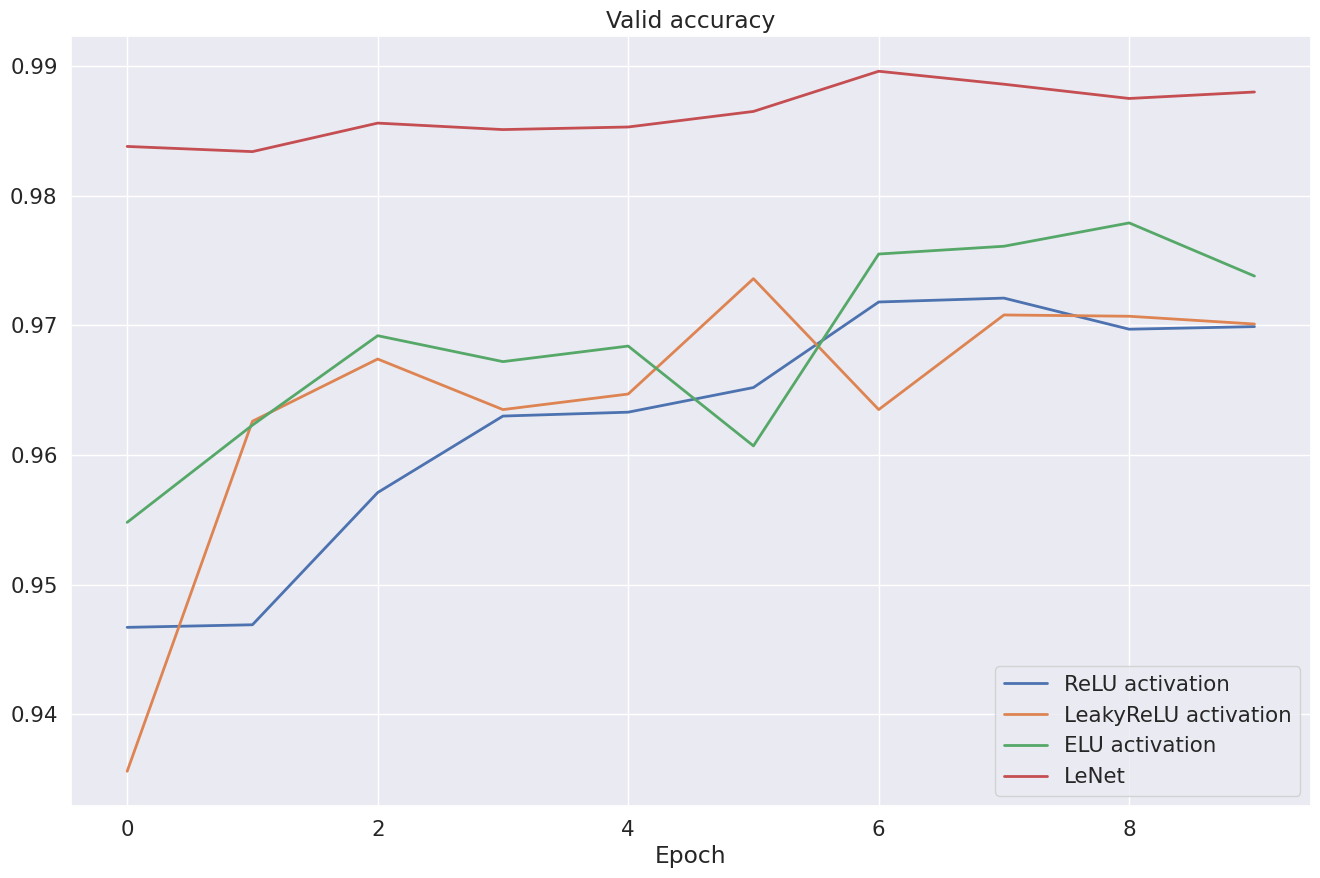

In [51]:
sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [52]:
lenet_accuracy[-1]

0.988

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98